# Facial Emotion Recogination

reference : https://www.kaggle.com/gauravsharma99/facial-emotion-recognition

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import cv2

In [2]:
import math
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from tensorflow.keras import optimizers

from keras.utils import np_utils

Importing Dataset

In [3]:
train_dir = 'fer2013/modified/train/'
test_dir = 'fer2013/modified/test/'

row, col = 48, 48
classes = 3
emotion_labels = ['angry', 'happy', 'neutral']

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print('sum of train : ', sum(train_count.iloc[0]))
print(test_count)
print('sum of test : ', sum(test_count.iloc[0]))

       angry  happy  neutral
train   3860   6722     4648
sum of train :  15230
      angry  happy  neutral
test    907   1621     1101
sum of test :  3629


Plot of number of images in training set

<AxesSubplot:>

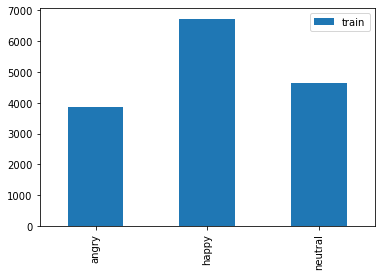

In [5]:
train_count.transpose().plot(kind='bar')

Plot of number of images in test set

<AxesSubplot:>

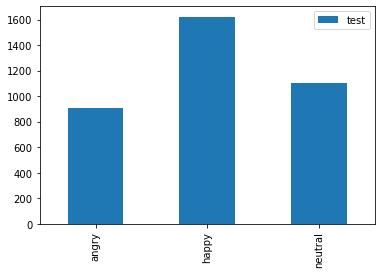

In [6]:
test_count.transpose().plot(kind='bar')

(48, 48, 3)
(48, 48, 3)
(48, 48, 3)


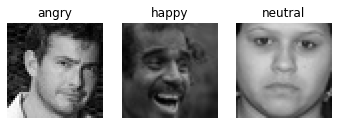

In [7]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    print(np.asarray(img).shape)
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

Creating Training and Test sets

In [8]:
train_datagen = ImageDataGenerator(rescale=(1./255 - 0.5)*2.0,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size= 64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=(1./255 - 0.5)*2.0)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size= 64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 15230 images belonging to 3 classes.
Found 3629 images belonging to 3 classes.


In [9]:
test_set

In [10]:
training_set.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2}

Defining Model

In [35]:
img_width, img_height, img_depth = 48, 48, 1
num_classes = 3


def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [19]:
fernet = build_net(Adam(lr=0.0001, decay=1e-6))

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

In [20]:
# !pip install pydot
# !pip install graphviz
# !pip install pydotplus
# !pip install django-extensions
# !pip install pyparsing

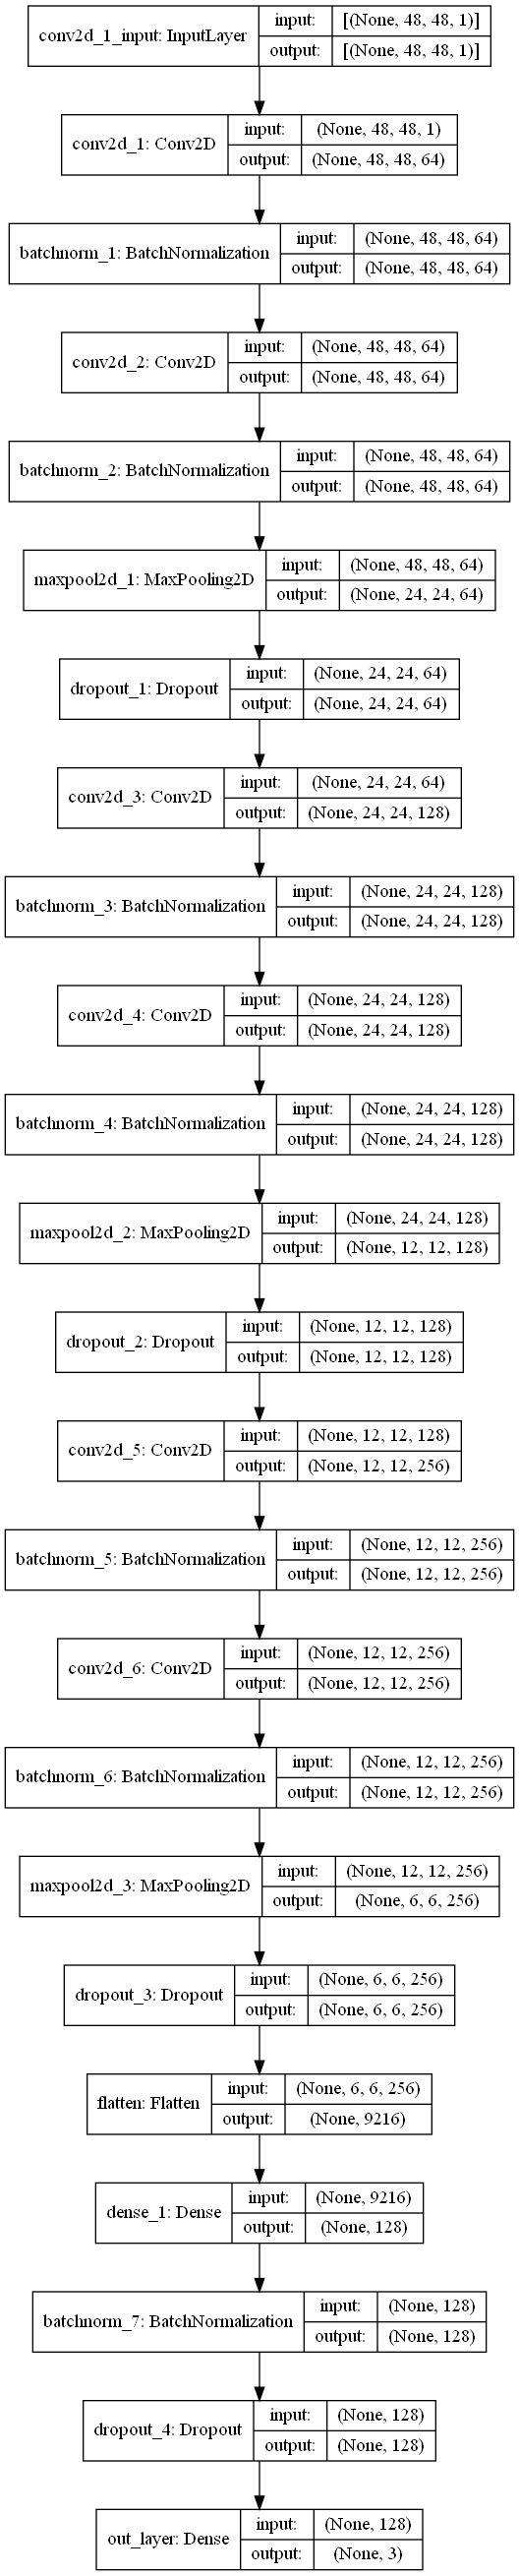

In [24]:
from keras.utils.vis_utils import plot_model
plot_model(fernet, to_file='model_plot_2.png', show_shapes=True, show_layer_names=True)

Callbacks Function

In [26]:
chk_path = 'models_2_2/{epoch:02d}-{val_accuracy:.2f}.h5'
log_dir = "models_2_2/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Training Model

In [28]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
237/237 [==============================] - 1226s 5s/step - loss: 1.9863 - accuracy: 0.3680 - val_loss: 0.9843 - val_accuracy: 0.5795

Epoch 00001: val_loss improved from inf to 0.98425, saving model to models_2_2\01-0.58.h5
Epoch 2/60
237/237 [==============================] - 1291s 5s/step - loss: 1.5486 - accuracy: 0.4421 - val_loss: 0.9841 - val_accuracy: 0.5745

Epoch 00002: val_loss improved from 0.98425 to 0.98412, saving model to models_2_2\02-0.57.h5
Epoch 3/60
237/237 [==============================] - 1320s 6s/step - loss: 1.3548 - accuracy: 0.4709 - val_loss: 0.9754 - val_accuracy: 0.5815

Epoch 00003: val_loss improved from 0.98412 to 0.97536, saving model to models_2_2\03-0.58.h5
Epoch 4/60
237/237 [==============================] - 1220s 5s/step - loss: 1.2849 - accuracy: 0.4798 - val_loss: 0.9176 - val_accuracy: 0.6018

Epoch 00004: val_loss improved from 0.97536 to 0.91762, saving model to models_2_2\04-0.60.h5
Epoch 5/60
237/237 [============================


Epoch 00036: val_loss improved from 0.48031 to 0.47244, saving model to models_2_2\36-0.81.h5
Epoch 37/60
237/237 [==============================] - 1022s 4s/step - loss: 0.5760 - accuracy: 0.7588 - val_loss: 0.4783 - val_accuracy: 0.8086

Epoch 00037: val_loss did not improve from 0.47244
Epoch 38/60
237/237 [==============================] - 1020s 4s/step - loss: 0.5626 - accuracy: 0.7671 - val_loss: 0.4737 - val_accuracy: 0.8086

Epoch 00038: val_loss did not improve from 0.47244
Epoch 39/60
237/237 [==============================] - 1019s 4s/step - loss: 0.5447 - accuracy: 0.7821 - val_loss: 0.4758 - val_accuracy: 0.8111

Epoch 00039: val_loss did not improve from 0.47244
Epoch 40/60
237/237 [==============================] - 1027s 4s/step - loss: 0.5376 - accuracy: 0.7819 - val_loss: 0.4651 - val_accuracy: 0.8225

Epoch 00040: val_loss improved from 0.47244 to 0.46511, saving model to models_2_2\40-0.82.h5
Epoch 41/60
237/237 [==============================] - 1027s 4s/step - los

Loss and Accuracy plot

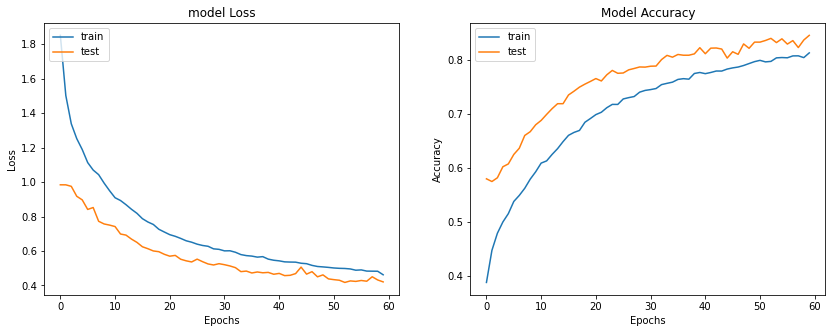

In [29]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

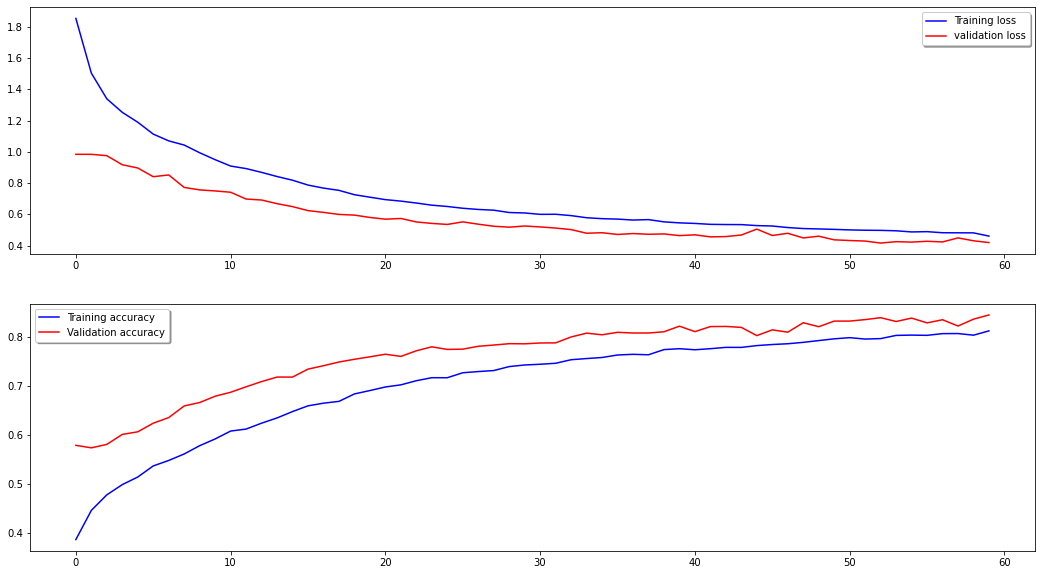

In [30]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Model Evaluation

In [31]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

57/57 [==============================] - 64s 1s/step - loss: 0.4212 - accuracy: 0.8446
final train accuracy = 84.58 , validation accuracy = 84.46


In [32]:
fernet.save_weights('model_bestweight_2_2.h5')

In [33]:
fernet.save('model_best_2_2.h5')

Confusion Matrix and Classification on training set

In [34]:
per = np.random.permutation(training_set.n)
training_set.index_array = per
classes = training_set.classes[per]

Confusion Matrix
[[2833  317  710]
 [ 156 6280  286]
 [ 475  442 3731]]
Classification Report
              precision    recall  f1-score   support

       angry       0.82      0.73      0.77      3860
       happy       0.89      0.93      0.91      6722
     neutral       0.79      0.80      0.80      4648

    accuracy                           0.84     15230
   macro avg       0.83      0.82      0.83     15230
weighted avg       0.84      0.84      0.84     15230



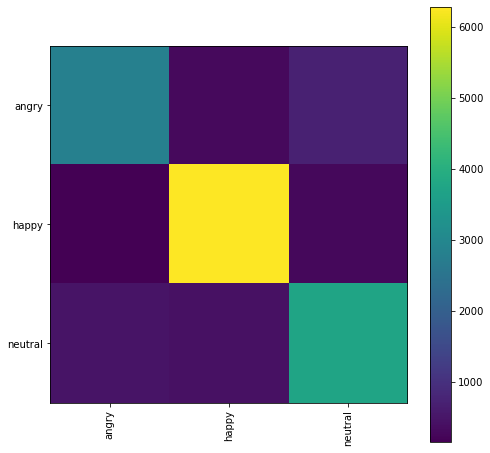

In [35]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix and Classification on test set

In [36]:
from keras.models import load_model
fernet = load_model('model_best_2_2.h5')

In [37]:
per = np.random.permutation(test_set.n)
test_set.index_array = per
classes = test_set.classes[per]

Confusion Matrix
[[ 652   65  190]
 [  64 1483   74]
 [  97   74  930]]
Classification Report
              precision    recall  f1-score   support

       angry       0.80      0.72      0.76       907
       happy       0.91      0.91      0.91      1621
     neutral       0.78      0.84      0.81      1101

    accuracy                           0.84      3629
   macro avg       0.83      0.83      0.83      3629
weighted avg       0.85      0.84      0.84      3629



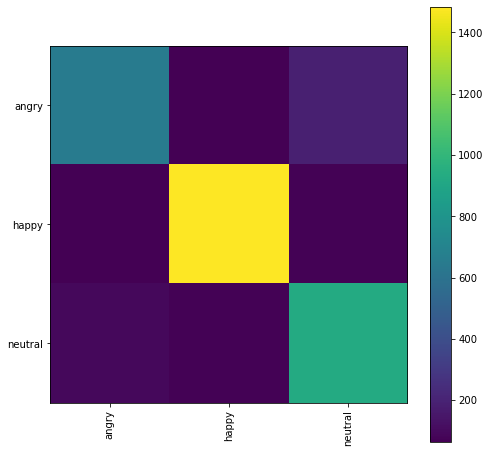

In [38]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [39]:
test_set.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2}

# 단일 사진 결과 확인

In [68]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import cv2
import numpy as np
import sys
import time
#from google.colab.patches import cv2_imshow
 
# parameters for loading data and images
detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
#emotion_model_path = 'ferNet.h5'
emotion_model_path = 'model_best_2_2.h5'
img_path =  "1.jpg" # sys.argv[1]
 
# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ['angry',  'happy', 'sadness', 'neutral'] # , 'sad', 'surprise']
 
# reading the frame
orig_frame = cv2.imread(img_path)
#print(img_path)
#print(orig_frame)
frame = cv2.imread(img_path,0)
#print(frame)
faces = face_detection.detectMultiScale(frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
 
if len(faces) > 0:
    print(faces)
    faces = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = faces
    roi = frame[fY:fY + fH, fX:fX + fW]
    roi = cv2.resize(roi, (48, 48))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    cv2.putText(orig_frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    cv2.rectangle(orig_frame, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)
 
cv2.imshow('test_face', orig_frame)
#cv2_imshow(orig_frame)
cv2.imwrite('test_output/'+img_path.split('/')[-1],orig_frame)
if (cv2.waitKey(0) and 0xFF == ord('q')):
    sys.exit("Thanks")
cv2.destroyAllWindows()

[[ 83  23 132 132]]


In [ ]:
roi.shape

# 실시간 영상을 통한 결과 확인

In [69]:
from statistics import mode

import cv2
from keras.models import load_model
import numpy as np

from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.preprocessor import preprocess_input

# parameters for loading data and images
detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
#emotion_model_path = 'ferNet.h5'
emotion_model_path = 'model_best_2_2.h5'
emotion_labels = ['angry', 'happy', 'sadness', 'neutral'] # , 'sad']

# hyper-parameters for bounding boxes shape
frame_window = 10
emotion_offsets = (20, 40)

# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]

# starting lists for calculating modes
emotion_window = []

In [70]:
emotion_labels

['angry', 'happy', 'sadness', 'neutral']

In [71]:
from keras.preprocessing.image import img_to_array

# starting video streaming
cv2.namedWindow('window_frame')
video_capture = cv2.VideoCapture(0)
while True:
    bgr_image = video_capture.read()[1]
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    faces = detect_faces(face_detection, gray_image)
    
    for face_coordinates in faces:

        x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
        gray_face = gray_image[y1:y2, x1:x2]
        try:
            gray_face = cv2.resize(gray_face, (emotion_target_size))
        except:
            continue

        gray_face = preprocess_input(gray_face, True)
        gray_face = np.expand_dims(gray_face, 0)
        gray_face = np.expand_dims(gray_face, -1)
        emotion_prediction = emotion_classifier.predict(gray_face)
        emotion_probability = np.max(emotion_prediction)
        emotion_label_arg = np.argmax(emotion_prediction)
        print(emotion_label_arg)
        emotion_text = emotion_labels[emotion_label_arg]
        print(emotion_text)
        emotion_window.append(emotion_text)

        if len(emotion_window) > frame_window:
            emotion_window.pop(0)
        try:
            emotion_mode = mode(emotion_window)
        except:
            continue

        if emotion_text == 'angry':
            color = emotion_probability * np.asarray((255, 0, 0))
        elif emotion_text == 'happy':
            color = emotion_probability * np.asarray((0, 0, 255))
        elif emotion_text == 'neutral':
            color = emotion_probability * np.asarray((255, 255, 0))
        elif emotion_text == 'sad':
            color = emotion_probability * np.asarray((0, 255, 255))
        else:
            color = emotion_probability * np.asarray((0, 255, 0))

        color = color.astype(int)
        color = color.tolist()

        draw_bounding_box(face_coordinates, rgb_image, color)
        if emotion_probability >= 0.7:
            draw_text(face_coordinates, rgb_image, emotion_mode,
                      color, 0, -45, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[0])+' : '+str(round(emotion_prediction[0][0],2)),
                  [0, 99, 99], 250, 10, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[1])+' : '+str(round(emotion_prediction[0][1],2)),
                  [99, 0, 99], 250, 60, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[2])+' : '+str(round(emotion_prediction[0][2],2)),
                  [0, 99, 0], 250, 110, 1, 1)
        #draw_text(face_coordinates, rgb_image, str(emotion_labels[3])+' : '+str(round(emotion_prediction[0][6],2)),
        #          [0, 0, 0], 250, 160, 1, 1)
        
        
        
    bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    cv2.imshow('window_frame', bgr_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

3
neutral
2
sadness
3
neutral
3
neutral
0
angry
3
neutral
0
angry
0
angry
0
angry
2
sadness
0
angry
3
neutral
0
angry
3
neutral
0
angry
0
angry
0
angry
0
angry
0
angry
0
angry
0
angry
2
sadness
0
angry
0
angry
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
0
angry
0
angry
0
angry
0
angry
0
angry
0
angry
0
angry
0
angry
0
angry
2
sadness
2
sadness
3
neutral
2
sadness
2
sadness
2
sadness
0
angry
0
angry
0
angry
0
angry
0
angry
0
angry
2
sadness
0
angry
0
angry
0
angry
2
sadness
2
sadness
0
angry
0
angry
0
angry
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
3
neutral
0
angry
0
angry
0
angry
2
sadness
0
angry
2
sadness
2
sadness
2
sadness
